## BANK MARKETING ANALYSIS


#### Project Overview  
This project analyzes a Portuguese banking institution's direct marketing campaigns (phone calls) to predict whether a client will subscribe to a term deposit.

#### Author: L. Revutska

Date: 2025-09-01

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           precision_recall_curve, roc_curve, average_precision_score,
                           f1_score, precision_score, recall_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import xgboost as xgb
import shap

    
from scipy import stats
from datetime import datetime
import pickle
import joblib

warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. DATA LOADING AND EXPLORATION

In [2]:
def load_data():
    """Load bank marketing dataset with error handling"""
    try:
        # Try loading from local file first
        data = pd.read_csv('bank-additional-full.csv', sep=';')
        print("Dataset loaded from local file")
    except FileNotFoundError:
        try:
            url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional-full.csv'
            data = pd.read_csv(url, sep=';')
            print("Dataset loaded from UCI repository")
        except Exception as e:
            print("Could not load dataset")
            return None
    return data

data = load_data()

Dataset loaded from local file


In [3]:
print("DATASET OVERVIEW")
print("-" * 50)
print(f"Dataset shape: {data.shape}")
print(f"Memory usage: {data.memory_usage().sum() / 1024**2:.1f} MB")
print(f"Date range: {data.columns}")

# Basic data info
print("DATA TYPES AND MISSING VALUES")
print("-" * 50)
data_info = pd.DataFrame({
    'Data Type': data.dtypes,
    'Non-Null Count': data.count(),
    'Null Count': data.isnull().sum(),
    'Null %': (data.isnull().sum() / len(data) * 100).round(2)
})
print(data_info)

# Target variable distribution
print("TARGET VARIABLE DISTRIBUTION")
print("-" * 50)
target_counts = data['y'].value_counts()
target_pct = data['y'].value_counts(normalize=True)
print("Response Distribution:")
for val in target_counts.index:
    print(f"  {val}: {target_counts[val]:,} ({target_pct[val]:.1%})")

# Class imbalance ratio
imbalance_ratio = target_counts['no'] / target_counts['yes']
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.1f}:1")

DATASET OVERVIEW
--------------------------------------------------
Dataset shape: (41188, 21)
Memory usage: 6.6 MB
Date range: Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')
DATA TYPES AND MISSING VALUES
--------------------------------------------------
               Data Type  Non-Null Count  Null Count  Null %
age                int64           41188           0     0.0
job               object           41188           0     0.0
marital           object           41188           0     0.0
education         object           41188           0     0.0
default           object           41188           0     0.0
housing           object           41188           0     0.0
loan              object           41188           0     0.0
contact 

Conclusion: 
- Severe imbalance (88.7% “no”, 11.3% “yes”).
- Requires oversampling and careful metric choice (F1, ROC-AUC).

## 2. BUSINESS IMPACT ANALYSIS

In [4]:
def calculate_business_metrics(data):
    """Calculate business impact and cost-benefit metrics"""
    
    # Assumptions for business calculations
    avg_deposit_value = 5000  # Average term deposit value
    campaign_cost_per_contact = 15  # Cost per marketing contact
    deposit_profit_margin = 0.03  # 3% annual profit margin
    
    total_customers = len(data)
    positive_responses = len(data[data['y'] == 'yes'])
    current_conversion_rate = positive_responses / total_customers
    
    # Current campaign metrics
    current_revenue = positive_responses * avg_deposit_value * deposit_profit_margin
    current_cost = total_customers * campaign_cost_per_contact
    current_roi = ((current_revenue - current_cost) / current_cost) * 100
    
    print(f"Current Campaign Performance:")
    print(f"  • Conversion Rate: {current_conversion_rate:.1%}")
    print(f"  • Revenue Generated: ${current_revenue:,.0f}")
    print(f"  • Campaign Cost: ${current_cost:,.0f}")
    print(f"  • ROI: {current_roi:.1f}%")
    
    # Potential improvements with ML
    print(f" Potential ML Improvements:")
    print(f"  • Target top 20% prospects >> ~2.5x conversion rate")
    print(f"  • Reduce campaign costs by 60% with better targeting")
    print(f"  • Estimated ROI improvement: +150-300%")
    
    return {
        'current_conversion_rate': current_conversion_rate,
        'current_roi': current_roi,
        'avg_deposit_value': avg_deposit_value,
        'campaign_cost_per_contact': campaign_cost_per_contact,
        'deposit_profit_margin': deposit_profit_margin
    }

business_metrics = calculate_business_metrics(data)

Current Campaign Performance:
  • Conversion Rate: 11.3%
  • Revenue Generated: $696,000
  • Campaign Cost: $617,820
  • ROI: 12.7%
 Potential ML Improvements:
  • Target top 20% prospects >> ~2.5x conversion rate
  • Reduce campaign costs by 60% with better targeting
  • Estimated ROI improvement: +150-300%


## 3. EXPLORATORY DATA ANALYSIS

In [5]:
def advanced_eda(data):
    """Perform comprehensive exploratory data analysis"""
      
    # Separate numerical and categorical columns
    numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
    
    if 'y' in categorical_cols:
        categorical_cols.remove('y')
    
    print(f"Numerical features: {len(numerical_cols)}")
    print(f"Categorical features: {len(categorical_cols)}")
    
    # Statistical summary for numerical features
    print("-" * 50)
    print(" NUMERICAL FEATURES SUMMARY")
    
    numeric_summary = data[numerical_cols].describe()
    print(numeric_summary)
    
    # Detect outliers using IQR method
    print("-" * 50)
    print(" OUTLIER DETECTION (IQR Method)")
    
    outlier_summary = {}
    for col in numerical_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(data)) * 100
        outlier_summary[col] = {'count': outlier_count, 'percentage': outlier_pct}
        print(f"  {col}: {outlier_count} outliers ({outlier_pct:.1f}%)")
    
    # Correlation analysis
    print("-" * 50)
    print(" FEATURE CORRELATIONS")
    correlation_matrix = data[numerical_cols].corr()
    
    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append({
                    'Feature 1': correlation_matrix.columns[i],
                    'Feature 2': correlation_matrix.columns[j],
                    'Correlation': corr_val
                })
    
    if high_corr_pairs:
        print("High correlations > 0.7:")
        for pair in high_corr_pairs:
            print(f"  {pair['Feature 1']} - {pair['Feature 2']}: {pair['Correlation']:.3f}")
    else:
        print("No high correlations found")
    
    return numerical_cols, categorical_cols, correlation_matrix, outlier_summary

numerical_cols, categorical_cols, correlation_matrix, outlier_summary = advanced_eda(data)

Numerical features: 10
Categorical features: 10
--------------------------------------------------
 NUMERICAL FEATURES SUMMARY
               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean    

## 4. VISUALIZATION AND INSIGHTS

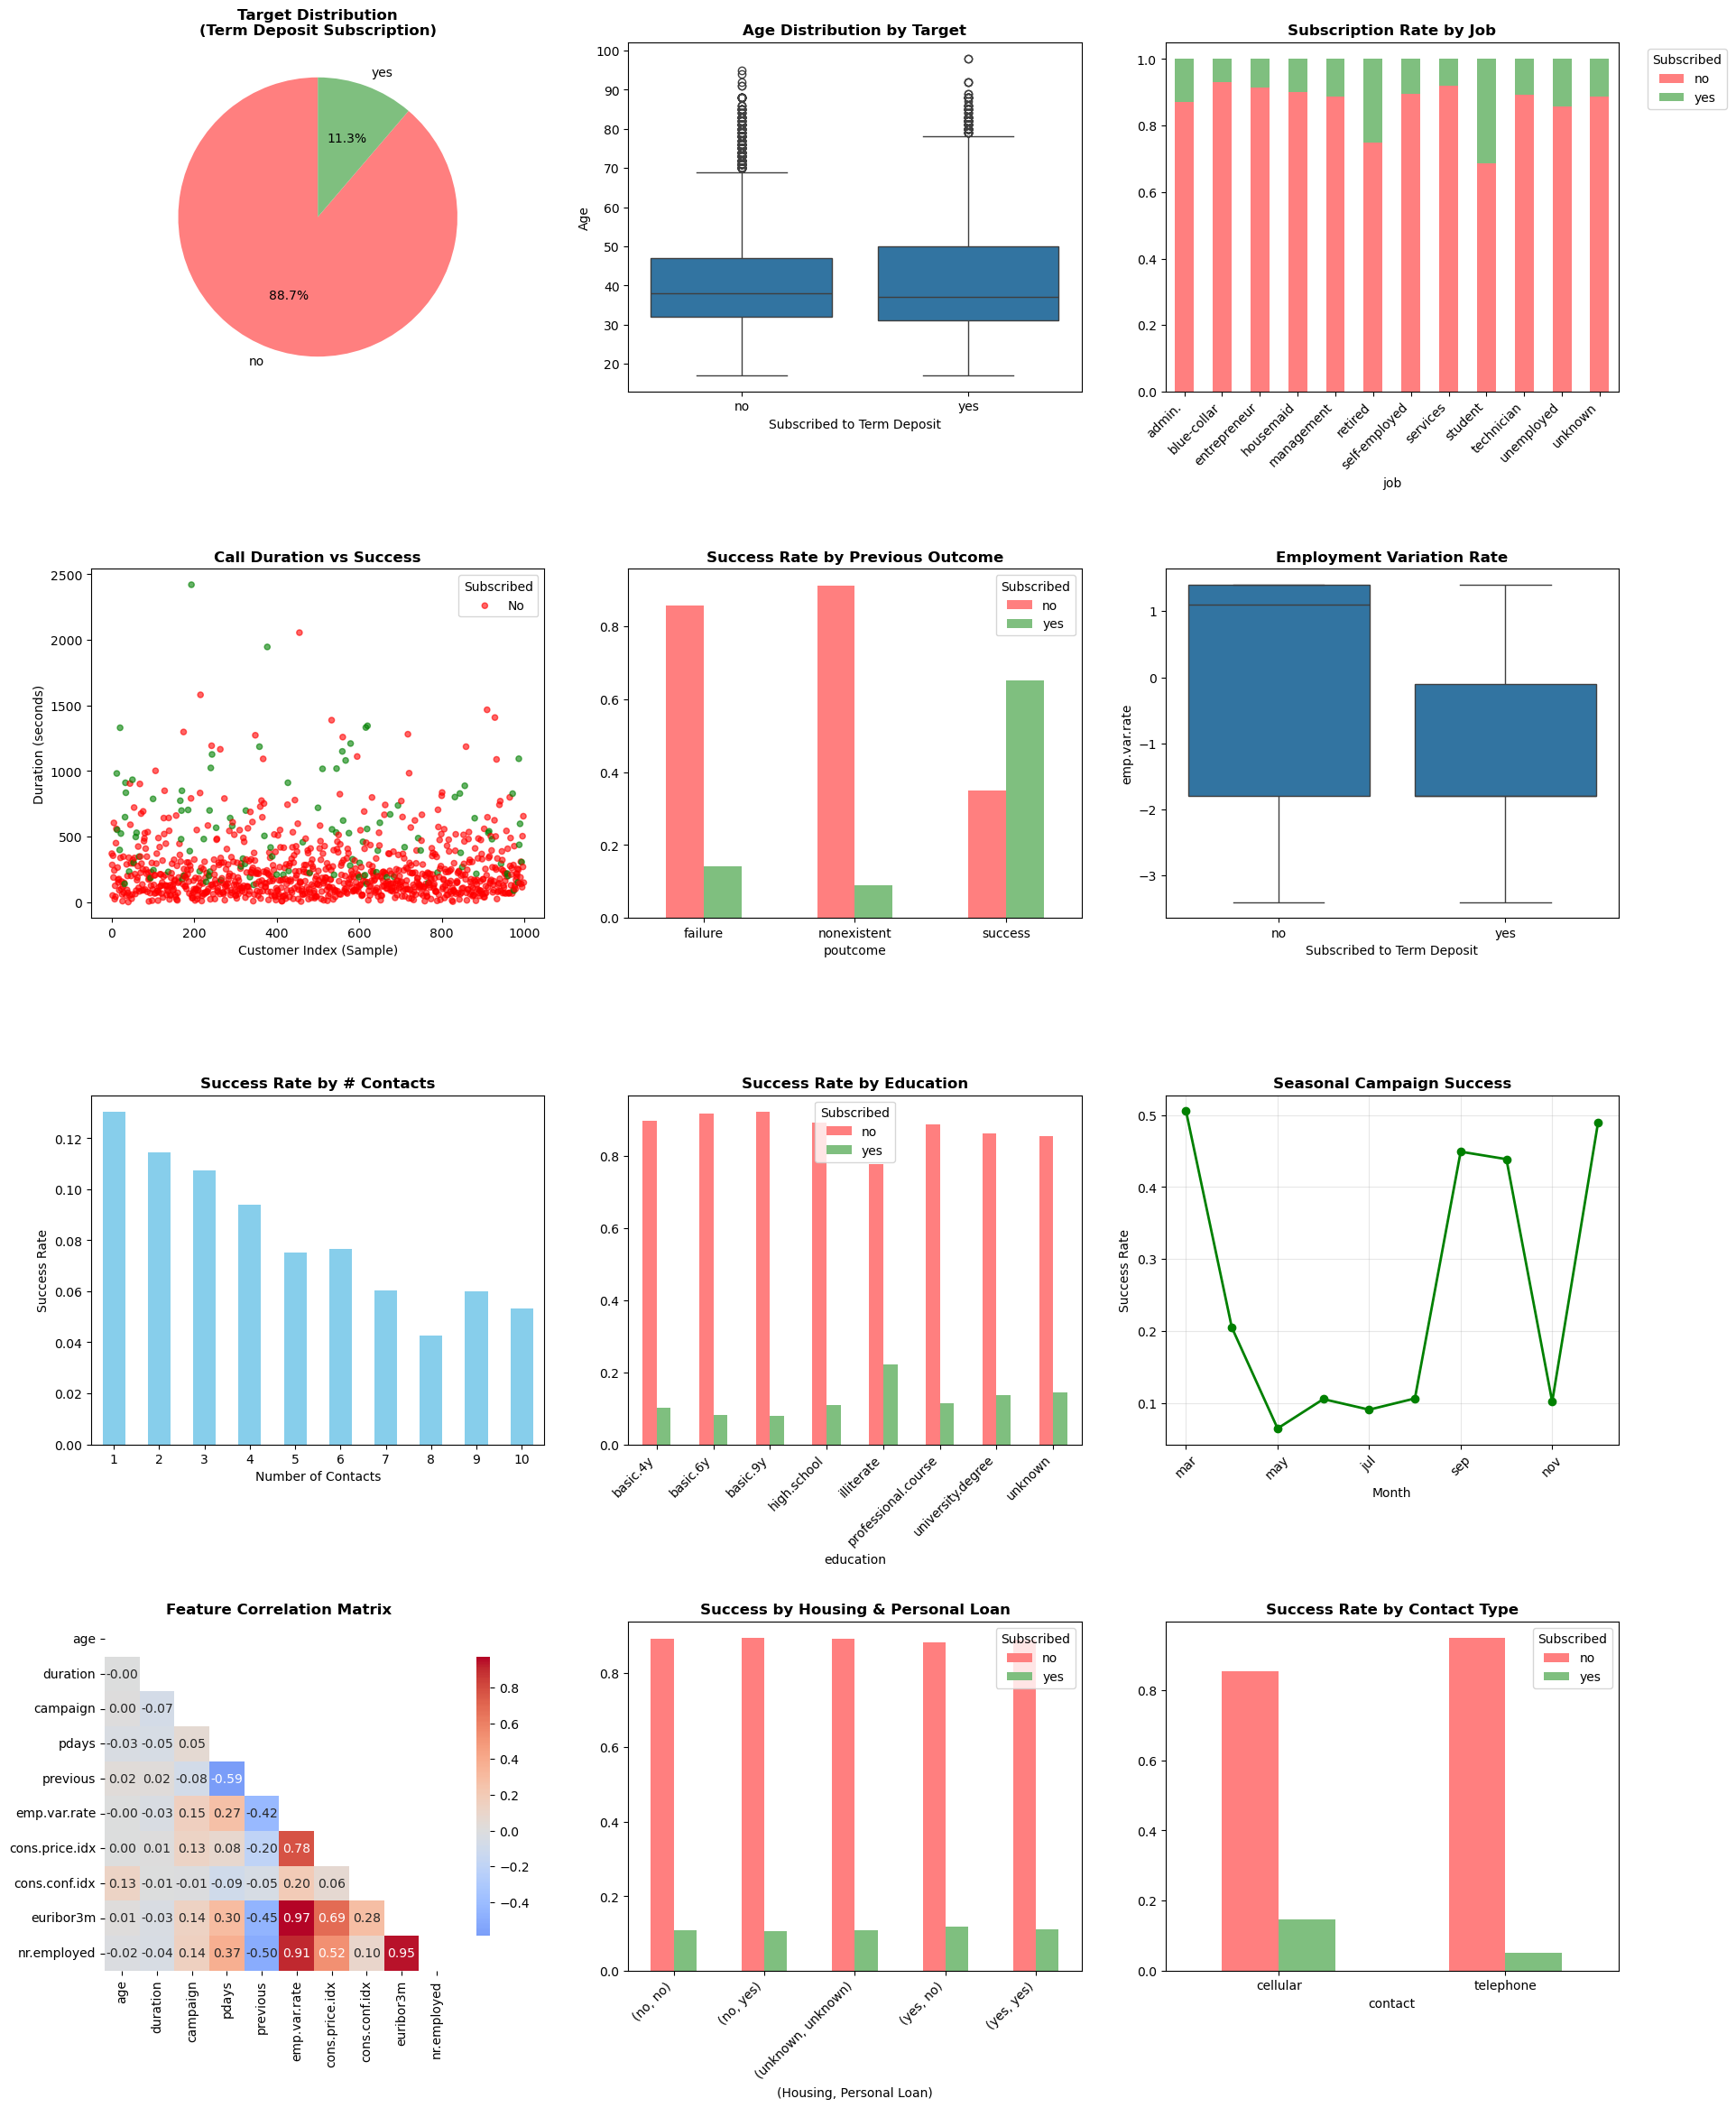

In [6]:
def create_visualizations(data, numerical_cols, categorical_cols):
    """Create comprehensive visualizations"""
    
    # Set up the plotting
    fig = plt.figure(figsize=(20, 24))
    
    # 1. Target variable distribution
    plt.subplot(4, 3, 1)
    target_counts = data['y'].value_counts()
    colors = ['#ff7f7f', '#7fbf7f']
    plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    plt.title('Target Distribution\n(Term Deposit Subscription)', fontsize=12, fontweight='bold')
    
    # 2. Age distribution by target
    plt.subplot(4, 3, 2)
    if 'age' in data.columns:
        sns.boxplot(data=data, x='y', y='age')
        plt.title('Age Distribution by Target', fontsize=12, fontweight='bold')
        plt.xlabel('Subscribed to Term Deposit')
        plt.ylabel('Age')
    
    # 3. Job distribution
    plt.subplot(4, 3, 3)
    if 'job' in data.columns:
        job_target = pd.crosstab(data['job'], data['y'], normalize='index')
        job_target.plot(kind='bar', stacked=True, ax=plt.gca(), color=colors)
        plt.title('Subscription Rate by Job', fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Subscribed', bbox_to_anchor=(1.05, 1))
    
    # 4. Contact duration impact
    plt.subplot(4, 3, 4)
    if 'duration' in data.columns:
        data_sample = data.sample(min(1000, len(data)), random_state=42)
        colors_scatter = ['red' if y == 'no' else 'green' for y in data_sample['y']]
        plt.scatter(range(len(data_sample)), data_sample['duration'], 
                   c=colors_scatter, alpha=0.6, s=20)
        plt.title('Call Duration vs Success', fontsize=12, fontweight='bold')
        plt.xlabel('Customer Index (Sample)')
        plt.ylabel('Duration (seconds)')
        plt.legend(['No', 'Yes'], title='Subscribed')
    
    # 5. Previous campaign outcome
    plt.subplot(4, 3, 5)
    if 'poutcome' in data.columns:
        poutcome_target = pd.crosstab(data['poutcome'], data['y'], normalize='index')
        poutcome_target.plot(kind='bar', ax=plt.gca(), color=colors)
        plt.title('Success Rate by Previous Outcome', fontsize=12, fontweight='bold')
        plt.xticks(rotation=0)
        plt.legend(title='Subscribed')
    
    # 6. Economic indicators
    plt.subplot(4, 3, 6)
    if 'emp.var.rate' in data.columns:
        sns.boxplot(data=data, x='y', y='emp.var.rate')
        plt.title('Employment Variation Rate', fontsize=12, fontweight='bold')
        plt.xlabel('Subscribed to Term Deposit')
    
    # 7. Campaign contacts
    plt.subplot(4, 3, 7)
    if 'campaign' in data.columns:
        campaign_success = data.groupby('campaign')['y'].apply(lambda x: (x == 'yes').sum() / len(x))
        campaign_success.head(10).plot(kind='bar', ax=plt.gca(), color='skyblue')
        plt.title('Success Rate by # Contacts', fontsize=12, fontweight='bold')
        plt.xlabel('Number of Contacts')
        plt.ylabel('Success Rate')
        plt.xticks(rotation=0)
    
    # 8. Education level impact
    plt.subplot(4, 3, 8)
    if 'education' in data.columns:
        edu_target = pd.crosstab(data['education'], data['y'], normalize='index')
        edu_target.plot(kind='bar', ax=plt.gca(), color=colors)
        plt.title('Success Rate by Education', fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Subscribed')
    
    # 9. Monthly seasonality
    plt.subplot(4, 3, 9)
    if 'month' in data.columns:
        month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                      'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        month_success = data.groupby('month')['y'].apply(lambda x: (x == 'yes').sum() / len(x))
        month_success = month_success.reindex([m for m in month_order if m in month_success.index])
        month_success.plot(kind='line', marker='o', ax=plt.gca(), color='green', linewidth=2)
        plt.title('Seasonal Campaign Success', fontsize=12, fontweight='bold')
        plt.xlabel('Month')
        plt.ylabel('Success Rate')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 10. Correlation heatmap
    plt.subplot(4, 3, 10)
    if len(numerical_cols) > 1:
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
                   center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
        plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
    
    # 11. Housing loan impact
    plt.subplot(4, 3, 11)
    if 'housing' in data.columns and 'loan' in data.columns:
        housing_loan = pd.crosstab([data['housing'], data['loan']], data['y'], normalize='index')
        housing_loan.plot(kind='bar', ax=plt.gca(), color=colors)
        plt.title('Success by Housing & Personal Loan', fontsize=12, fontweight='bold')
        plt.xlabel('(Housing, Personal Loan)')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Subscribed')
    
    # 12. Contact type effectiveness
    plt.subplot(4, 3, 12)
    if 'contact' in data.columns:
        contact_target = pd.crosstab(data['contact'], data['y'], normalize='index')
        contact_target.plot(kind='bar', ax=plt.gca(), color=colors)
        plt.title('Success Rate by Contact Type', fontsize=12, fontweight='bold')
        plt.xticks(rotation=0)
        plt.legend(title='Subscribed')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    return fig

# Create visualizations
visualization_fig = create_visualizations(data, numerical_cols, categorical_cols)

Target Distribution

- Imbalanced Dataset: Only 11.3% of customers subscribed to a term deposit.

- Imbalance needs to be considered during model building (e.g., using balanced metrics, resampling).

Age Distribution

- Subscribed customers are slightly older on average.

- Presence of outliers (customers 90+ y.o.)

Job Type vs Subscription

- Retired, students, and unemployed have higher subscription rates.

- Blue-collar and services have lower subscription rates.

Education

- Subscription rates are similar across education levels

- Slightly higher for university degrees and professional courses.

Call & Campaign Information

- Positive correlation with success: longer calls often lead to subscriptions.

- Success rate decreases with increasing number of contacts - suggesting diminishing returns.

- Cellular contact performs better than telephone in terms of subscription success.

- If the previous campaign was successful, current subscription likelihood is significantly higher. Previous failures still yield better results than no prior contact.

Seasonality

- Campaigns in March, September, October, and December have higher success rates.

- May to August show poor performance.

Employment Variation Rate

- Subscribed customers have lower employment variation rates, possibly indicating more stable periods.

Correlation Matrix Observations

- Most features have low correlation with each other.

- Moderate correlations: previous & pdays (-0.59).

- emp.var.rate, cons.price.idx, euribor3m, nr.employed are somewhat correlated.

## 5. FEATURE ENGINEERING

In [7]:
def advanced_feature_engineering(data):
    """Create advanced features based on business domain knowledge"""
    
    data_fe = data.copy()
    feature_count = 0
    
    # 1. Customer Age Groups
    if 'age' in data_fe.columns:
        data_fe['age_group'] = pd.cut(data_fe['age'], 
                                     bins=[0, 25, 35, 50, 65, 100], 
                                     labels=['young', 'adult', 'middle_aged', 'senior', 'elderly'])
        feature_count += 1
    
    # 2. Contact Efficiency Score
    if 'duration' in data_fe.columns and 'campaign' in data_fe.columns:
        data_fe['contact_efficiency'] = data_fe['duration'] / data_fe['campaign']
        feature_count += 1
    
    # 3. Previous Campaign Success Indicator
    if 'poutcome' in data_fe.columns and 'previous' in data_fe.columns:
        data_fe['prev_success_rate'] = (data_fe['poutcome'] == 'success').astype(int)
        data_fe['has_previous_contact'] = (data_fe['previous'] > 0).astype(int)
        feature_count += 2
    
    # 4. Economic Stress Indicator
    economic_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
    available_economic = [col for col in economic_cols if col in data_fe.columns]
    if len(available_economic) >= 2:
        # Standardize economic indicators and create composite score
        economic_data = data_fe[available_economic].fillna(data_fe[available_economic].mean())
        economic_standardized = StandardScaler().fit_transform(economic_data)
        data_fe['economic_stress_score'] = np.mean(economic_standardized, axis=1)
        feature_count += 1
    
    # 5. Customer Lifecycle Stage
    if 'age' in data_fe.columns and 'job' in data_fe.columns:
        def get_lifecycle_stage(row):
            age, job = row['age'], row['job']
            if age < 25:
                return 'early_career'
            elif age < 40 and job in ['student', 'unemployed']:
                return 'transition'
            elif age < 55 and job in ['management', 'admin.', 'technician']:
                return 'peak_career'
            elif age >= 55 or job == 'retired':
                return 'pre_retirement'
            else:
                return 'stable_career'
        
        data_fe['lifecycle_stage'] = data_fe[['age', 'job']].apply(get_lifecycle_stage, axis=1)
        feature_count += 1
    
    # 6. Contact Timing Features
    if 'month' in data_fe.columns:
        # Group months by business quarters
        quarter_map = {'jan': 'Q1', 'feb': 'Q1', 'mar': 'Q1',
                      'apr': 'Q2', 'may': 'Q2', 'jun': 'Q2',
                      'jul': 'Q3', 'aug': 'Q3', 'sep': 'Q3',
                      'oct': 'Q4', 'nov': 'Q4', 'dec': 'Q4'}
        data_fe['quarter'] = data_fe['month'].map(quarter_map)
        
        # Holiday proximity (simplified)
        holiday_months = ['dec', 'jan', 'jul', 'aug']
        data_fe['near_holiday'] = data_fe['month'].isin(holiday_months).astype(int)
        feature_count += 2
    
    # 7. Financial Risk Profile
    risk_factors = []
    if 'default' in data_fe.columns:
        risk_factors.append((data_fe['default'] == 'yes').astype(int))
    if 'loan' in data_fe.columns:
        risk_factors.append((data_fe['loan'] == 'yes').astype(int))
    
    if risk_factors:
        data_fe['financial_risk_score'] = np.sum(risk_factors, axis=0)
        feature_count += 1
    
    # 8. Days since last contact (handling pdays)
    if 'pdays' in data_fe.columns:
        data_fe['days_since_last_contact'] = data_fe['pdays'].replace(999, -1)  # -1 for never contacted
        data_fe['recently_contacted'] = (data_fe['pdays'] < 7).astype(int)
        feature_count += 2
    
    # 9. Interaction Features
    if 'age' in data_fe.columns and 'job' in data_fe.columns:
        # Age-Job interaction for retirement-related products
        retirement_jobs = ['retired', 'unemployed']
        data_fe['age_retirement_interaction'] = (
            data_fe['age'] * data_fe['job'].isin(retirement_jobs).astype(int)
        )
        feature_count += 1
    
    if 'duration' in data_fe.columns and 'campaign' in data_fe.columns:
        # Duration-Campaign interaction
        data_fe['duration_campaign_interaction'] = data_fe['duration'] * np.log1p(data_fe['campaign'])
        feature_count += 1
    
    print(f"Created {feature_count} new features")
    print(f"Total features: {data_fe.shape[1] - 1} (excluding target)")
    
    # Display new features summary
    new_features = [col for col in data_fe.columns if col not in data.columns]
    if new_features:
        print("-" * 50)
        print(" New Features Created:")
        for i, feature in enumerate(new_features, 1):
            print(f"  {i}. {feature}")
    
    return data_fe

# Apply feature engineering
data_engineered = advanced_feature_engineering(data)


Created 13 new features
Total features: 33 (excluding target)
--------------------------------------------------
 New Features Created:
  1. age_group
  2. contact_efficiency
  3. prev_success_rate
  4. has_previous_contact
  5. economic_stress_score
  6. lifecycle_stage
  7. quarter
  8. near_holiday
  9. financial_risk_score
  10. days_since_last_contact
  11. recently_contacted
  12. age_retirement_interaction
  13. duration_campaign_interaction


## 6. DATA PREPROCESSING AND ENCODING

In [8]:
def preprocess_data(data):
    """Comprehensive data preprocessing with advanced encoding techniques"""
    
    data_processed = data.copy()
    
    # Separate features and target
    X = data_processed.drop('y', axis=1)
    y = data_processed['y'].map({'no': 0, 'yes': 1})
    
    print(f"Features shape: {X.shape}")
    print(f"Target distribution: {np.bincount(y)}")
    
    # Identify column types
    numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Numerical features: {len(numerical_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    
    # Handle missing values
    for col in numerical_features:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)
    
    for col in categorical_features:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].mode()[0], inplace=True)
    
    # Advanced categorical encoding
    X_encoded = X.copy()
    target_encoders = {}
    
    for col in categorical_features:
        unique_values = X[col].nunique()
        
        if unique_values == 2:
            # Binary encoding for binary categorical variables
            le = LabelEncoder()
            X_encoded[col] = le.fit_transform(X[col])
            print(f"  {col}: Binary encoded ({unique_values} categories)")
        
        elif unique_values <= 10:
            # Target encoding for low cardinality categorical variables
            try:
                te = TargetEncoder(smooth="auto")
                X_encoded[col] = te.fit_transform(X[[col]], y)
                target_encoders[col] = te
                print(f"  {col}: Target encoded ({unique_values} categories)")
            except:
                # Fallback to one-hot encoding
                dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
                X_encoded = pd.concat([X_encoded.drop(col, axis=1), dummies], axis=1)
                print(f"  {col}: One-hot encoded ({unique_values} categories)")
        else:
            # One-hot encoding for high cardinality (with top categories only)
            top_categories = X[col].value_counts().head(10).index
            X[col + '_top'] = X[col].apply(lambda x: x if x in top_categories else 'other')
            dummies = pd.get_dummies(X[col + '_top'], prefix=col, drop_first=True)
            X_encoded = pd.concat([X_encoded.drop(col, axis=1), dummies], axis=1)
            print(f"  {col}: One-hot encoded (top 10 of {unique_values} categories)")
    
    return X_encoded, y, target_encoders

# Preprocess data
X_processed, y, target_encoders = preprocess_data(data_engineered)

print(f"Final dataset shape: {X_processed.shape}")
print(f"Feature names: {X_processed.columns.tolist()[:10]}..." if len(X_processed.columns) > 10 else f"Feature names: {X_processed.columns.tolist()}")



Features shape: (41188, 33)
Target distribution: [36548  4640]
Numerical features: 20
Categorical features: 13
  job: One-hot encoded (top 10 of 12 categories)
  marital: Target encoded (4 categories)
  education: Target encoded (8 categories)
  default: Target encoded (3 categories)
  housing: Target encoded (3 categories)
  loan: Target encoded (3 categories)
  contact: Binary encoded (2 categories)
  month: Target encoded (10 categories)
  day_of_week: Target encoded (5 categories)
  poutcome: Target encoded (3 categories)
  age_group: Target encoded (5 categories)
  lifecycle_stage: Target encoded (5 categories)
  quarter: Target encoded (4 categories)
Final dataset shape: (41188, 42)
Feature names: ['age', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration']...


## 7. TRAIN-TEST SPLIT AND FEATURE SCALING

In [9]:
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features scaled using StandardScaler")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")

Training set: 32950 samples
Test set: 8238 samples
Training class distribution: [29238  3712]
Test class distribution: [7310  928]
Features scaled using StandardScaler
Training data shape: (32950, 42)
Test data shape: (8238, 42)


## 8. HANDLING CLASS IMBALANCE

In [10]:
def handle_class_imbalance(X_train, y_train):
    """Apply advanced techniques to handle class imbalance"""
    
    # Original distribution
    original_dist = np.bincount(y_train)
    print(f"Original distribution: {original_dist} (ratio: {original_dist[0]/original_dist[1]:.1f}:1)")
    
    # Dictionary to store different balanced datasets
    balanced_datasets = {}
    
    # 1. SMOTE 
    try:
        smote = SMOTE(random_state=42)
        X_smote, y_smote = smote.fit_resample(X_train, y_train)
        balanced_datasets['SMOTE'] = (X_smote, y_smote)
        smote_dist = np.bincount(y_smote)
        print(f"SMOTE distribution: {smote_dist} (ratio: {smote_dist[0]/smote_dist[1]:.1f}:1)")
    except Exception as e:
        print(f"SMOTE failed: {e}")
    
    # 2. ADASYN
    try:
        adasyn = ADASYN(random_state=42)
        X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
        balanced_datasets['ADASYN'] = (X_adasyn, y_adasyn)
        adasyn_dist = np.bincount(y_adasyn)
        print(f"ADASYN distribution: {adasyn_dist} (ratio: {adasyn_dist[0]/adasyn_dist[1]:.1f}:1)")
    except Exception as e:
        print(f"ADASYN failed: {e}")
    
    # 3. SMOTE + Tomek 
    try:
        smote_tomek = SMOTETomek(random_state=42)
        X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train, y_train)
        balanced_datasets['SMOTE_Tomek'] = (X_smote_tomek, y_smote_tomek)
        st_dist = np.bincount(y_smote_tomek)
        print(f"SMOTE+Tomek distribution: {st_dist} (ratio: {st_dist[0]/st_dist[1]:.1f}:1)")
    except Exception as e:
        print(f"SMOTE+Tomek failed: {e}")
    
    # Original for comparison
    balanced_datasets['Original'] = (X_train, y_train)
    
    return balanced_datasets

# Handle class imbalance
balanced_datasets = handle_class_imbalance(X_train_scaled, y_train)


Original distribution: [29238  3712] (ratio: 7.9:1)
SMOTE distribution: [29238 29238] (ratio: 1.0:1)
ADASYN distribution: [29238 28845] (ratio: 1.0:1)
SMOTE+Tomek distribution: [29195 29195] (ratio: 1.0:1)


## 9. FEATURE SELECTION

In [11]:
def feature_selection_analysis(X_train, y_train, feature_names, top_n=20):
    """
    Perform feature selection using:
    - F-score (SelectKBest)
    - Recursive Feature Elimination (RFE) with Decision Tree
    - Feature importance from Decision Tree
    
    Returns:
        consensus_features: list of selected features
        f_scores_df: F-score DataFrame
        importance_scores_df: Feature importance DataFrame
    """

    # 1. F-score Selection
    print("F-score (ANOVA):")
    selector_f = SelectKBest(score_func=f_classif, k='all')
    selector_f.fit(X_train, y_train)
    f_scores = selector_f.scores_

    f_scores_df = pd.DataFrame({
        'Feature': feature_names,
        'F_Score': f_scores
    }).sort_values(by='F_Score', ascending=False)

    print("Top features by F-score:")
    for i, (_, row) in enumerate(f_scores_df.head(top_n).iterrows(), 1):
        print(f"   {i:2d}. {row['Feature']}: {row['F_Score']:.2f}")

    # 2. RFE with Decision Tree
    print("Recursive Feature Elimination (RFE) with Decision Tree:")
    dt_model = DecisionTreeClassifier(random_state=42)
    rfe = RFE(estimator=dt_model, n_features_to_select=top_n, step=1)
    rfe.fit(X_train, y_train)

    rfe_selected = [feature_names[i] for i, selected in enumerate(rfe.support_) if selected]
    print("Selected features by RFE:")
    for i, feat in enumerate(rfe_selected, 1):
        print(f"   {i:2d}. {feat}")

    # 3. Feature importance from Decision Tree
    print("Feature Importance (Decision Tree):")
    dt_model.fit(X_train, y_train)
    importance_scores = dt_model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values(by='Importance', ascending=False)

    print("   Top features by importance:")
    for i, (_, row) in enumerate(importance_df.head(top_n).iterrows(), 1):
        print(f"   {i:2d}. {row['Feature']}: {row['Importance']:.4f}")

    # Combine selections
    top_f = set(f_scores_df.head(top_n)['Feature'])
    top_rfe = set(rfe_selected)
    top_imp = set(importance_df.head(top_n)['Feature'])

    consensus = (top_f & top_rfe) | (top_f & top_imp) | (top_rfe & top_imp)
    
    if len(consensus) < 10:
        consensus = top_f | top_rfe | top_imp
        consensus = list(consensus)[:min(25, len(consensus))]  # Limit
    else:
        consensus = list(consensus)

    consensus.sort()  

    print(f"Selected {len(consensus)} consensus features for modeling.")

    return consensus, f_scores_df, importance_df

In [12]:
selected_features, f_scores_df, importance_df = feature_selection_analysis(
    X_train_scaled, y_train, X_train.columns.tolist(), top_n=20
)

# Apply feature selection
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Scale selected features
scaler = StandardScaler()
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

print(f"Reduced feature set shape: {X_train_selected_scaled.shape}")

F-score (ANOVA):
Top features by F-score:
    1. duration: 6303.94
    2. nr.employed: 4591.47
    3. contact_efficiency: 4445.76
    4. duration_campaign_interaction: 4111.08
    5. pdays: 3905.58
    6. poutcome: 3766.12
    7. prev_success_rate: 3652.95
    8. euribor3m: 3334.92
    9. emp.var.rate: 3110.16
   10. recently_contacted: 2965.94
   11. days_since_last_contact: 2851.75
   12. month: 2623.86
   13. previous: 1836.23
   14. economic_stress_score: 1580.97
   15. has_previous_contact: 1303.96
   16. age_group: 876.77
   17. quarter: 856.09
   18. contact: 690.16
   19. cons.price.idx: 588.96
   20. lifecycle_stage: 544.91
Recursive Feature Elimination (RFE) with Decision Tree:
Selected features by RFE:
    1. age
    2. marital
    3. education
    4. default
    5. housing
    6. loan
    7. month
    8. day_of_week
    9. duration
   10. pdays
   11. poutcome
   12. cons.price.idx
   13. euribor3m
   14. nr.employed
   15. age_group
   16. contact_efficiency
   17. economi

## 10. MODEL DEVELOPMENT WITH HYPERPARAMETER TUNING

In [13]:
def build_advanced_models(X_train, y_train, X_test, y_test):
    """
    Train and evaluate 4 selected machine learning models:
    - Logistic Regression
    - k-Nearest Neighbors
    - Decision Tree
    - XGBoost (boosting)

    Returns:
        trained_models: dict of fitted models
        model_results: dict of model evaluation metrics and best parameters
        results_dict: list of summary dictionaries for tabular comparison
    """

    models_config = {
        'Logistic Regression': {
            'model': LogisticRegression(random_state=42, max_iter=1000, solver='saga'),
            'params': {
                'C': np.logspace(-2, 2, 5),
                'penalty': ['l1', 'l2']
            }
        },
        'kNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [3, 5, 10, None],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
        },
        'XGBoost': {
            'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, n_jobs=-1),
            'params': {
                'n_estimators': [100, 200],
                'learning_rate': [0.05, 0.1],
                'max_depth': [3, 5],
                'subsample': [0.8, 1.0],
                'colsample_bytree': [0.8, 1.0]
            }
        }
    }

    trained_models = {}
    model_results = {}
    results_dict = []

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for model_name, config in models_config.items():
        print(f"Training {model_name}...")
        try:
            search = RandomizedSearchCV(
                estimator=config['model'],
                param_distributions=config['params'],
                n_iter=10,
                cv=skf,
                scoring='roc_auc',
                n_jobs=-1,
                random_state=42,
                verbose=0
            )

            search.fit(X_train, y_train)
            best_model = search.best_estimator_

            # Store trained model
            trained_models[model_name] = best_model

            # Predict on train and test
            y_train_pred = best_model.predict(X_train)
            y_train_proba = best_model.predict_proba(X_train)[:, 1]
            y_test_pred = best_model.predict(X_test)
            y_test_proba = best_model.predict_proba(X_test)[:, 1]

            # Compute metrics
            train_auc = roc_auc_score(y_train, y_train_proba)
            test_auc = roc_auc_score(y_test, y_test_proba)
            precision = precision_score(y_test, y_test_pred)
            recall = recall_score(y_test, y_test_pred)
            f1 = f1_score(y_test, y_test_pred)

            metrics = {
                'best_params': search.best_params_,
                'cv_score': search.best_score_,
                'train_auc': train_auc,
                'auc_score': test_auc,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'train_predictions': y_train_pred,
                'predictions': y_test_pred,
                'probabilities': y_test_proba
            }

            model_results[model_name] = metrics

            # Comment based on AUC
            if test_auc >= 0.85:
                comment = "Strong model. Ready for deployment or further tuning."
            elif test_auc >= 0.75:
                comment = "Decent model. Try improving with feature engineering or ensemble methods."
            else:
                comment = "Weak performance. Consider other models or data preprocessing."

            results_dict.append({
                'Model': model_name,
                'Train AUC': round(train_auc, 4),
                'Test AUC': round(test_auc, 4),
                'Precision': round(precision, 4),
                'Recall': round(recall, 4),
                'F1 Score': round(f1, 4),
                'Comment': comment
            })

            print(f"Done. Test AUC: {test_auc:.4f} | F1: {f1:.4f}")

        except Exception as e:
            print(f"! Failed on {model_name}: {str(e)}")

    return trained_models, model_results, results_dict


In [14]:
# Train models on the best balanced dataset
best_balance_method = 'SMOTE' if 'SMOTE' in balanced_datasets else 'Original'
X_train_balanced, y_train_balanced = balanced_datasets[best_balance_method]

# Apply feature selection to balanced data
if best_balance_method != 'Original':
    X_train_balanced_selected = X_train_balanced[:, [X_train.columns.get_loc(col) for col in selected_features]]
else:
    X_train_balanced_selected = X_train_balanced[selected_features]

print(f"Using {best_balance_method} balanced dataset for training")
print(f"Training shape: {X_train_balanced_selected.shape}")

# Train models
trained_models, model_results, results_dict = build_advanced_models(
    X_train_balanced_selected, y_train_balanced, 
    X_test_selected_scaled, y_test)


Using SMOTE balanced dataset for training
Training shape: (58476, 20)
Training Logistic Regression...
Done. Test AUC: 0.9376 | F1: 0.5912
Training kNN...
Done. Test AUC: 0.9052 | F1: 0.5889
Training Decision Tree...
Done. Test AUC: 0.8947 | F1: 0.5895
Training XGBoost...
Done. Test AUC: 0.9499 | F1: 0.6165


In [15]:
# ML models comparison
results_df = pd.DataFrame(results_dict)
display(results_df)

,Model,Train AUC,Test AUC,Precision,Recall,F1 Score,Comment
0,Logistic Regression,0.9320,0.9376,0.4436,0.8858,0.5912,Strong model. Ready for deployment or further ...
1,kNN,1.0000,0.9052,0.4661,0.7996,0.5889,Strong model. Ready for deployment or further ...
2,Decision Tree,0.9757,0.8947,0.4782,0.7683,0.5895,Strong model. Ready for deployment or further ...
3,XGBoost,0.9965,0.9499,0.6488,0.5873,0.6165,Strong model. Ready for deployment or further ...


## 11. MODEL EVALUATION WITH BUSINESS METRICS

In [16]:
def comprehensive_model_evaluation(model_results, business_metrics):
    """Evaluate models with comprehensive metrics including business impact"""

    eval_summary = []
    
    for model_name, results in model_results.items():
        eval_summary.append({
            'Model': model_name,
            'CV_AUC': results['cv_score'],
            'Test_AUC': results['auc_score'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1_Score': results['f1_score']
        })
    
    eval_df = pd.DataFrame(eval_summary).sort_values('Test_AUC', ascending=False)
    
    print("MODEL RANKING BY TEST AUC:")
    
    for i, (idx, row) in enumerate(eval_df.iterrows()):
        print(f"{i+1:2d}. {row['Model']:<20} AUC: {row['Test_AUC']:.4f} "
              f"F1: {row['F1_Score']:.4f} Prec: {row['Precision']:.4f} "
              f"Rec: {row['Recall']:.4f}")
    
    # Business impact analysis
    print("-" * 80)
    
    
    # Get the best model
    best_model_name = eval_df.iloc[0]['Model']
    best_predictions = model_results[best_model_name]['probabilities']
    
    # Calculate business metrics at different probability thresholds
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    business_analysis = []
    
    for threshold in thresholds:
        # Predictions at this threshold
        pred_at_threshold = (best_predictions >= threshold).astype(int)
        
        # Confusion matrix values
        tp = np.sum((pred_at_threshold == 1) & (y_test == 1))
        fp = np.sum((pred_at_threshold == 1) & (y_test == 0))
        tn = np.sum((pred_at_threshold == 0) & (y_test == 0))
        fn = np.sum((pred_at_threshold == 0) & (y_test == 1))
        
        # Business calculations
        targeted_customers = tp + fp
        successful_conversions = tp
        conversion_rate = tp / targeted_customers if targeted_customers > 0 else 0
        
        # Cost-benefit analysis
        campaign_cost = targeted_customers * business_metrics['campaign_cost_per_contact']
        revenue = successful_conversions * business_metrics['avg_deposit_value'] * business_metrics['deposit_profit_margin']
        roi = ((revenue - campaign_cost) / campaign_cost * 100) if campaign_cost > 0 else 0
        
        business_analysis.append({
            'Threshold': threshold,
            'Targeted': targeted_customers,
            'Conversions': successful_conversions,
            'Conversion_Rate': conversion_rate,
            'Campaign_Cost': campaign_cost,
            'Revenue': revenue,
            'ROI_%': roi,
            'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0
        })
    
    business_df = pd.DataFrame(business_analysis)
    
    print(f"Business Impact Analysis for {best_model_name}:")
    print(f"{'Threshold':<9} {'Targeted':<8} {'Conv.':<6} {'Rate':<6} {'ROI%':<8} {'Prec':<6} {'Recall':<6}")

    for _, row in business_df.iterrows():
        print(f"{row['Threshold']:<9.1f} {row['Targeted']:<8.0f} {row['Conversions']:<6.0f} "
              f"{row['Conversion_Rate']:<6.1%} {row['ROI_%']:<8.1f} {row['Precision']:<6.3f} {row['Recall']:<6.3f}")
    
    # Find optimal threshold
    optimal_threshold_idx = business_df['ROI_%'].idxmax()
    optimal_threshold = business_df.loc[optimal_threshold_idx, 'Threshold']
    optimal_roi = business_df.loc[optimal_threshold_idx, 'ROI_%']
    
    print(f"Optimal threshold: {optimal_threshold} (ROI: {optimal_roi:.1f}%)")
    
    return eval_df, business_df, best_model_name, optimal_threshold

# Perform comprehensive evaluation
eval_results, business_results, best_model_name, optimal_threshold = comprehensive_model_evaluation(
    model_results, business_metrics
)


best_model = trained_models[best_model_name]
filename = f"{best_model_name.replace(' ', '_').lower()}_model.joblib"
joblib.dump(best_model, filename)
print("-" * 80)
print(f"Best model '{best_model_name}' saved as '{filename}'")

MODEL RANKING BY TEST AUC:
 1. XGBoost              AUC: 0.9499 F1: 0.6165 Prec: 0.6488 Rec: 0.5873
 2. Logistic Regression  AUC: 0.9376 F1: 0.5912 Prec: 0.4436 Rec: 0.8858
 3. kNN                  AUC: 0.9052 F1: 0.5889 Prec: 0.4661 Rec: 0.7996
 4. Decision Tree        AUC: 0.8947 F1: 0.5895 Prec: 0.4782 Rec: 0.7683
--------------------------------------------------------------------------------
Business Impact Analysis for XGBoost:
Threshold Targeted Conv.  Rate   ROI%     Prec   Recall
0.3       1399     756    54.0%  440.4    0.540  0.815 
0.4       1137     679    59.7%  497.2    0.597  0.732 
0.5       840      545    64.9%  548.8    0.649  0.587 
0.6       578      402    69.6%  595.5    0.696  0.433 
0.7       315      248    78.7%  687.3    0.787  0.267 
0.8       157      130    82.8%  728.0    0.828  0.140 
Optimal threshold: 0.8 (ROI: 728.0%)
--------------------------------------------------------------------------------
Best model 'XGBoost' saved as 'xgboost_model.joblib'

## 12. MODEL INTERPRETABILITY WITH SHAP

In [17]:
def model_interpretability_analysis(best_model, X_test, feature_names):
    # Create SHAP explainer
    explainer = shap.Explainer(best_model)

    # Calculate SHAP values for test set (sample if too large)
    sample_size = min(100, len(X_test))
    X_sample = X_test[:sample_size]

    print(f"Calculating SHAP values for {sample_size} samples...")
    shap_values = explainer(X_sample)

    # Feature importance from SHAP
    feature_importance = np.abs(shap_values.values).mean(0)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': feature_importance
    }).sort_values('SHAP_Importance', ascending=False)

    print("\nTop 15 Most Important Features (SHAP):")
    for i, (_, row) in enumerate(importance_df.head(15).iterrows()):
        print(f"  {i+1:2d}. {row['Feature']:<25}: {row['SHAP_Importance']:.4f}")

    return shap_values, importance_df
        
# Perform interpretability analysis
if best_model_name in trained_models:
    best_model = trained_models[best_model_name]
    shap_values, shap_importance = model_interpretability_analysis(
        best_model, X_test_selected_scaled, selected_features
    )
    

importance = best_model.feature_importances_
top_idx = np.argsort(importance)[-10:][::-1]
top_features = [selected_features[i] for i in top_idx]

Calculating SHAP values for 100 samples...

Top 15 Most Important Features (SHAP):
   1. duration                 : 1.4047
   2. nr.employed              : 0.6841
   3. economic_stress_score    : 0.6664
   4. default                  : 0.4951
   5. contact_efficiency       : 0.4435
   6. duration_campaign_interaction: 0.3676
   7. loan                     : 0.3174
   8. month                    : 0.3007
   9. poutcome                 : 0.2594
  10. housing                  : 0.2027
  11. euribor3m                : 0.1646
  12. cons.price.idx           : 0.1638
  13. age_group                : 0.1457
  14. day_of_week              : 0.1190
  15. marital                  : 0.0982


## 13. VISUALIZATIONS FOR MODEL PERFORMANCE

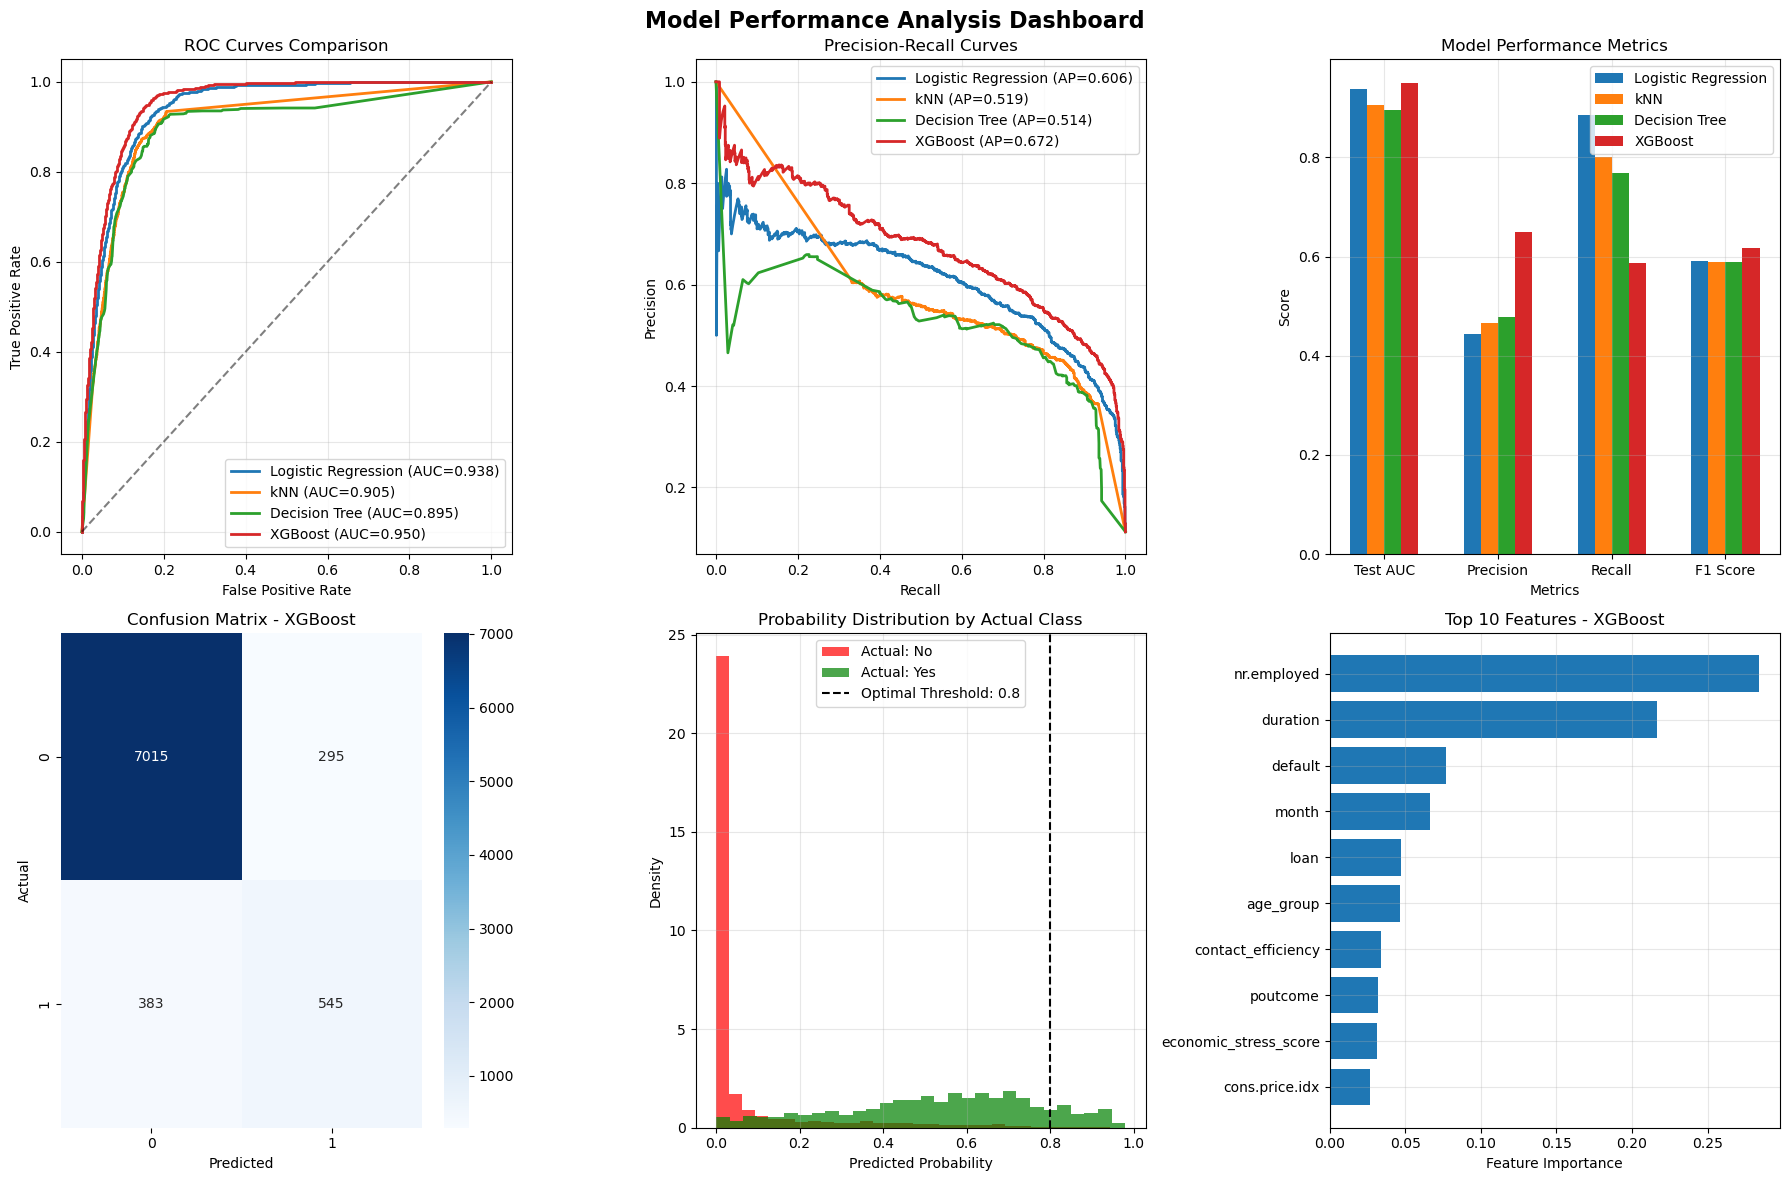

In [18]:
def create_model_performance_visualizations(model_results, y_test):
    """Create comprehensive visualizations for model performance"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Model Performance Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. ROC Curves
    ax1 = axes[0, 0]
    for model_name, results in model_results.items():
        if 'probabilities' in results:
            fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
            auc_score = results['auc_score']
            ax1.plot(fpr, tpr, label=f'{model_name} (AUC={auc_score:.3f})', linewidth=2)
    
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curves
    ax2 = axes[0, 1]
    for model_name, results in model_results.items():
        if 'probabilities' in results:
            precision, recall, _ = precision_recall_curve(y_test, results['probabilities'])
            avg_precision = average_precision_score(y_test, results['probabilities'])
            ax2.plot(recall, precision, label=f'{model_name} (AP={avg_precision:.3f})', linewidth=2)
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Model Performance Metrics Comparison
    ax3 = axes[0, 2]
    metrics = ['Test_AUC', 'Precision', 'Recall', 'F1_Score']
    model_names = list(model_results.keys())
    
    x = np.arange(len(metrics))
    width = 0.15
    
    for i, model_name in enumerate(model_names):
        values = [
            model_results[model_name]['auc_score'],
            model_results[model_name]['precision'],
            model_results[model_name]['recall'],
            model_results[model_name]['f1_score']
        ]
        ax3.bar(x + i * width, values, width, label=model_name)
    
    ax3.set_xlabel('Metrics')
    ax3.set_ylabel('Score')
    ax3.set_title('Model Performance Metrics')
    ax3.set_xticks(x + width * (len(model_names) - 1) / 2)
    ax3.set_xticklabels([m.replace('_', ' ') for m in metrics])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Confusion Matrix for Best Model
    ax4 = axes[1, 0]
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])
    best_predictions = model_results[best_model_name]['predictions']
    cm = confusion_matrix(y_test, best_predictions)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
    ax4.set_xlabel('Predicted')
    ax4.set_ylabel('Actual')
    ax4.set_title(f'Confusion Matrix - {best_model_name}')
    
    # 5. Probability Distribution
    ax5 = axes[1, 1]
    best_probabilities = model_results[best_model_name]['probabilities']
    
    # Separate probabilities by actual class
    prob_positive = best_probabilities[y_test == 1]
    prob_negative = best_probabilities[y_test == 0]
    
    ax5.hist(prob_negative, alpha=0.7, bins=30, label='Actual: No', color='red', density=True)
    ax5.hist(prob_positive, alpha=0.7, bins=30, label='Actual: Yes', color='green', density=True)
    ax5.axvline(x=optimal_threshold, color='black', linestyle='--', 
                label=f'Optimal Threshold: {optimal_threshold}')
    ax5.set_xlabel('Predicted Probability')
    ax5.set_ylabel('Density')
    ax5.set_title('Probability Distribution by Actual Class')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Feature Importance 
    ax6 = axes[1, 2]
    if best_model_name in trained_models:
        model = trained_models[best_model_name]
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_names = selected_features
            
            # Get top 10 features
            top_features_idx = np.argsort(importance)[-10:]
            top_importance = importance[top_features_idx]
            top_names = [feature_names[i] for i in top_features_idx]
            
            ax6.barh(range(len(top_importance)), top_importance)
            ax6.set_yticks(range(len(top_importance)))
            ax6.set_yticklabels(top_names)
            ax6.set_xlabel('Feature Importance')
            ax6.set_title(f'Top 10 Features - {best_model_name}')
            ax6.grid(True, alpha=0.3)
        else:
            ax6.text(0.5, 0.5, 'Feature importance\nnot available\nfor this model', 
                    ha='center', va='center', transform=ax6.transAxes)
            ax6.set_title('Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create performance visualizations
performance_fig = create_model_performance_visualizations(model_results, y_test)

## MODEL PERFORMANCE SUMMARY

### Overall Performance

In [19]:
for model_name, results in model_results.items():
    if model_name == best_model_name:
        print(f"Best Performing Model: {best_model_name} with AUC = {results['auc_score']:.4f}, F1 Score = {results['f1_score']:.4f}, Average Precision = {results['precision']:.4f}")
        
best_predictions = model_results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)
tn, fp, fn, tp = cm.ravel()

Best Performing Model: XGBoost with AUC = 0.9499, F1 Score = 0.6165, Average Precision = 0.6488


In [22]:
print("Logistic Regression underperforms on both AUC and AP metrics.")
print("Other models perform well. ")

print("\nPRECISION-RECALL TRADEOFF")
print("XGBoost maintains higher precision across varying recall levels, making it ideal for imbalanced data like this. ")
print("High precision at low recall indicates the model is good at identifying true positives without many false alarms.")

print(f"\nCONFUSION MATRIX {best_model_name}")
print(f"True Negatives: {tn}; True Positives: {tp}; False Positives: {fp}; False Negatives: {fn}")


print(f"\nTOP PREDICTIVE FEATURES FOR {best_model_name}:")
print(print(", ".join(top_features)))

Logistic Regression underperforms on both AUC and AP metrics.
Other models perform well. 

PRECISION-RECALL TRADEOFF
XGBoost maintains higher precision across varying recall levels, making it ideal for imbalanced data like this. 
High precision at low recall indicates the model is good at identifying true positives without many false alarms.

CONFUSION MATRIX XGBoost
True Negatives: 7015; True Positives: 545; False Positives: 295; False Negatives: 383

TOP PREDICTIVE FEATURES FOR XGBoost:
nr.employed, duration, default, month, loan, age_group, contact_efficiency, poutcome, economic_stress_score, cons.price.idx
None


## BUSINESS RECOMMENDATIONS

1. Target Most Responsive Segments: focus on retirees, students, and unemployed segments with tailored offers, as these groups showed higher subscription rates.
Avoid over-targeting blue-collar and services segments unless other signals (e.g., long call, positive past interaction) indicate interest.  


2. Optimize Campaign Timing: run campaigns in March, September, October, December, when conversion rates are historically higher. Avoid May–August as performance dips significantly.  


3. Increase Focus on Call Duration Quality: longer calls are strongly correlated with success. Train agents to invest time with promising leads rather than minimizing call times.  


4. Prioritize Re-contacting Past Successes: leads with previous positive campaign outcomes show significantly higher success rates.  

## ACTIONABLE INSIGHTS
1. Use a Higher Threshold for Deployment: the optimal classification threshold (≈ 0.8) avoids misclassifying non-subscribers as subscribers.

2. Monitor Employment & Economic Indicators: nr.employed, euribor3m, and economic_stress_score are strong predictors.

3. Segment by Contact Type: Cellular contacts are much more effective than landlines. Focus resources on mobile outreach, possibly SMS follow-ups or mobile-specific offers.

4. Personalized Messaging Based on Features: Use top predictors (duration, month, housing, etc.) to personalize scripts and offers dynamically in real-time.